In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing,

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor



In [2]:
data =  pd.read_csv('/kaggle/input/advertising-dataset/advertising.csv')
data.head(20)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
5,8.7,48.9,75.0,7.2
6,57.5,32.8,23.5,11.8
7,120.2,19.6,11.6,13.2
8,8.6,2.1,1.0,4.8
9,199.8,2.6,21.2,15.6


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [4]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


In [5]:
data.duplicated().sum()

0

## Exploratory Data Analysis - EDA

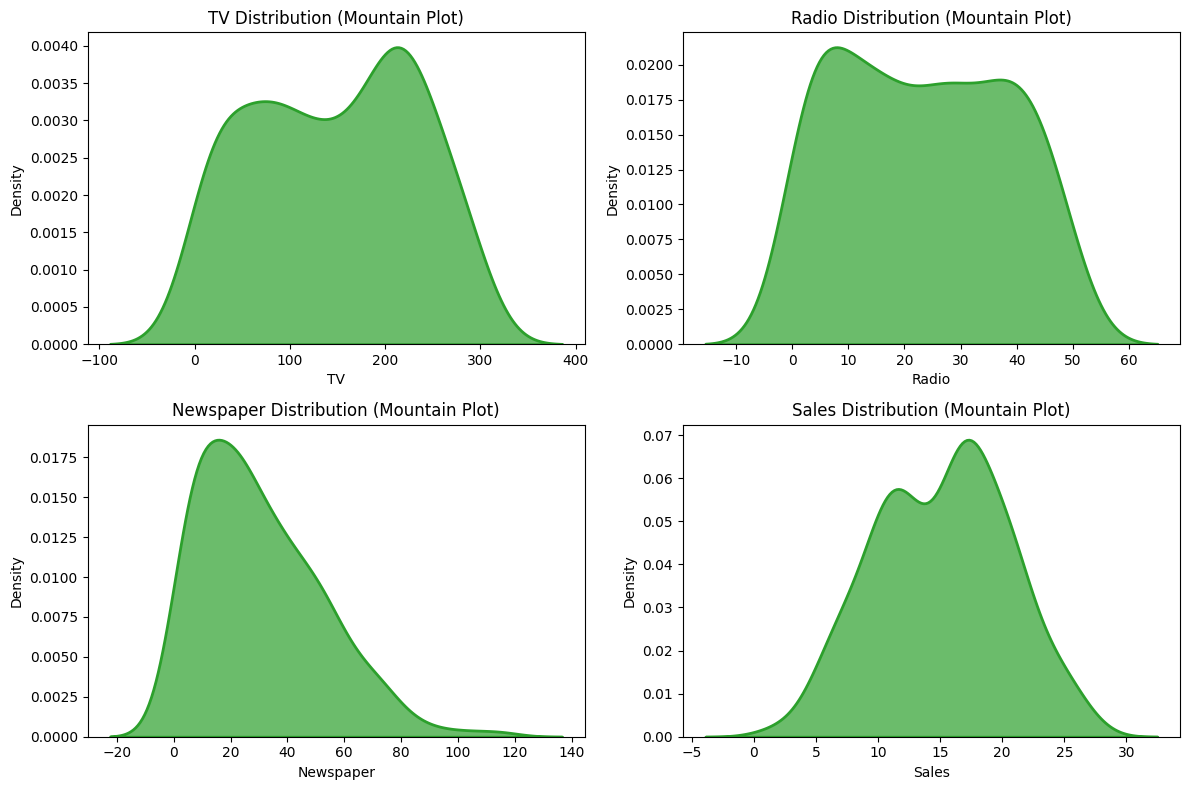

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['TV', 'Radio', 'Newspaper', 'Sales']
fill_color = '#2ca02c'  # Green
edge_color = '#1f6f1f'  # Dark green edge

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.kdeplot(data[feature], ax=axes[i], fill=True, color=fill_color, alpha=0.7, linewidth=2)
    axes[i].set_title(f'{feature} Distribution (Mountain Plot)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


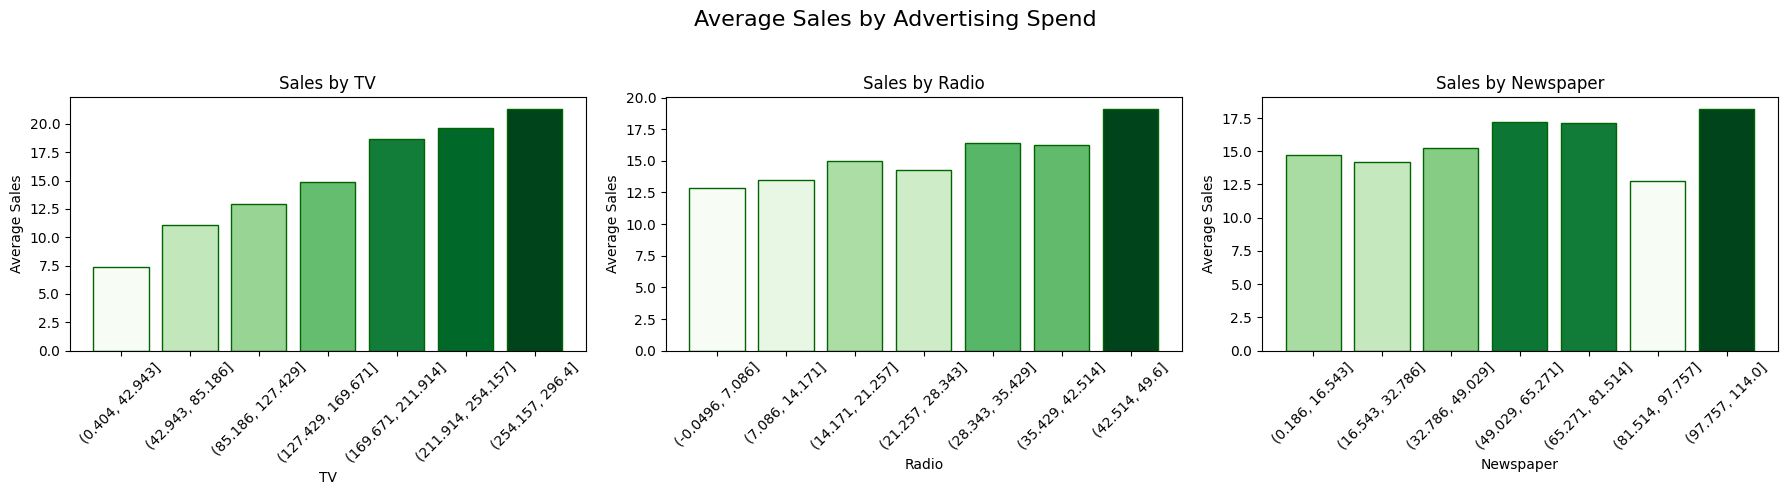

In [7]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Average Sales by Advertising Spend', fontsize=16)

# Columns to analyze
features = ['TV', 'Radio', 'Newspaper']

axes = axes.flatten()

for i, feature in enumerate(features):
    # Create bins for the numerical feature
    data[f'{feature}_bin'] = pd.cut(data[feature], bins=7)  # 7 bins

    # Calculate mean Sales per bin
    avg_sales = data.groupby(f'{feature}_bin')['Sales'].mean().reset_index()

    # Normalize for gradient (0 to 1)
    norm = (avg_sales['Sales'] - avg_sales['Sales'].min()) / (avg_sales['Sales'].max() - avg_sales['Sales'].min())
    
    # Generate gradient colors from light green to dark green
    colors = [plt.cm.Greens(x) for x in norm]

    # Plot bars manually with gradient colors
    axes[i].bar(avg_sales[f'{feature}_bin'].astype(str), avg_sales['Sales'], color=colors, edgecolor='darkgreen')
    axes[i].set_ylabel('Average Sales')
    axes[i].set_xlabel(feature)
    axes[i].set_title(f'Sales by {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [8]:
data

,TV,Radio,Newspaper,Sales,TV_bin,Radio_bin,Newspaper_bin
0,230.1,37.8,69.2,22.1,"(211.914, 254.157]","(35.429, 42.514]","(65.271, 81.514]"
1,44.5,39.3,45.1,10.4,"(42.943, 85.186]","(35.429, 42.514]","(32.786, 49.029]"
2,17.2,45.9,69.3,12.0,"(0.404, 42.943]","(42.514, 49.6]","(65.271, 81.514]"
3,151.5,41.3,58.5,16.5,"(127.429, 169.671]","(35.429, 42.514]","(49.029, 65.271]"
4,180.8,10.8,58.4,17.9,"(169.671, 211.914]","(7.086, 14.171]","(49.029, 65.271]"
...,...,...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,"(0.404, 42.943]","(-0.0496, 7.086]","(0.186, 16.543]"
196,94.2,4.9,8.1,14.0,"(85.186, 127.429]","(-0.0496, 7.086]","(0.186, 16.543]"
197,177.0,9.3,6.4,14.8,"(169.671, 211.914]","(7.086, 14.171]","(0.186, 16.543]"
198,283.6,42.0,66.2,25.5,"(254.157, 296.4]","(35.429, 42.514]","(65.271, 81.514]"


In [9]:
data.drop(columns=['TV_bin', 'Radio_bin', 'Newspaper_bin'], inplace=True)

In [10]:
data

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,14.0
197,177.0,9.3,6.4,14.8
198,283.6,42.0,66.2,25.5


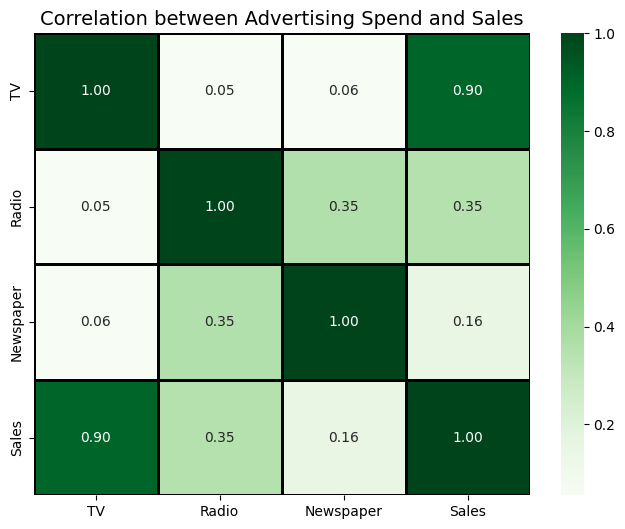

In [11]:
# Compute correlation matrix
corr_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt=".2f", linewidths=1, linecolor='black')
plt.title('Correlation between Advertising Spend and Sales', fontsize=14)
plt.show()

## Feature engineering

In [12]:
data['TV_Radio'] = data['TV'] * data['Radio']
data['TV_Newspaper'] = data['TV'] * data['Newspaper']
data['Radio_Newspaper'] = data['Radio'] * data['Newspaper']
data

,TV,Radio,Newspaper,Sales,TV_Radio,TV_Newspaper,Radio_Newspaper
0,230.1,37.8,69.2,22.1,8697.78,15922.92,2615.76
1,44.5,39.3,45.1,10.4,1748.85,2006.95,1772.43
2,17.2,45.9,69.3,12.0,789.48,1191.96,3180.87
3,151.5,41.3,58.5,16.5,6256.95,8862.75,2416.05
4,180.8,10.8,58.4,17.9,1952.64,10558.72,630.72
...,...,...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,141.34,527.16,51.06
196,94.2,4.9,8.1,14.0,461.58,763.02,39.69
197,177.0,9.3,6.4,14.8,1646.10,1132.80,59.52
198,283.6,42.0,66.2,25.5,11911.20,18774.32,2780.40


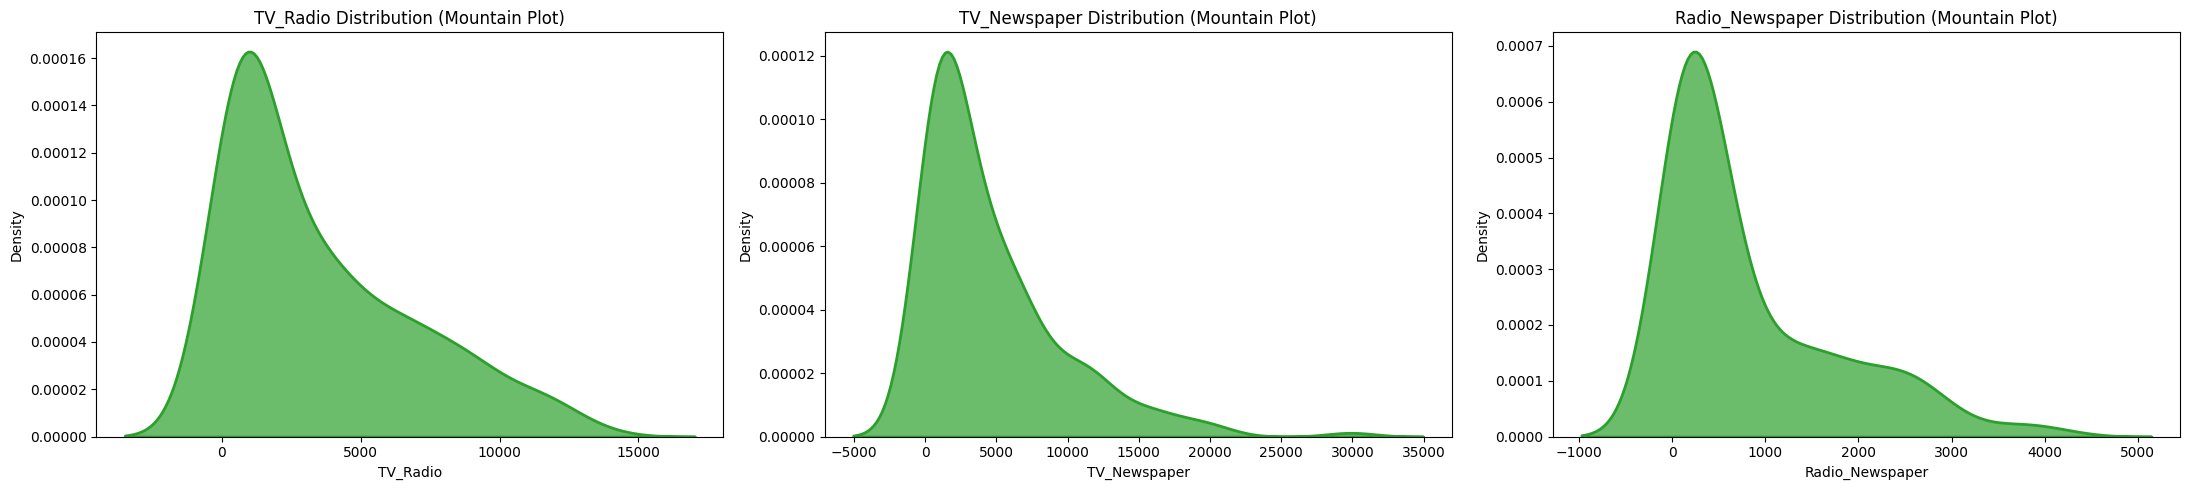

In [13]:
fill_color = '#2ca02c'  # Green
edge_color = '#1f6f1f'  # Dark green edge

fig, axes = plt.subplots(1, 3, figsize=(22, 5))
axes = axes.flatten()

for i, feature in enumerate(['TV_Radio',	'TV_Newspaper',	'Radio_Newspaper']):
    sns.kdeplot(data[feature], ax=axes[i], fill=True, color=fill_color, alpha=0.7, linewidth=2)
    axes[i].set_title(f'{feature} Distribution (Mountain Plot)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


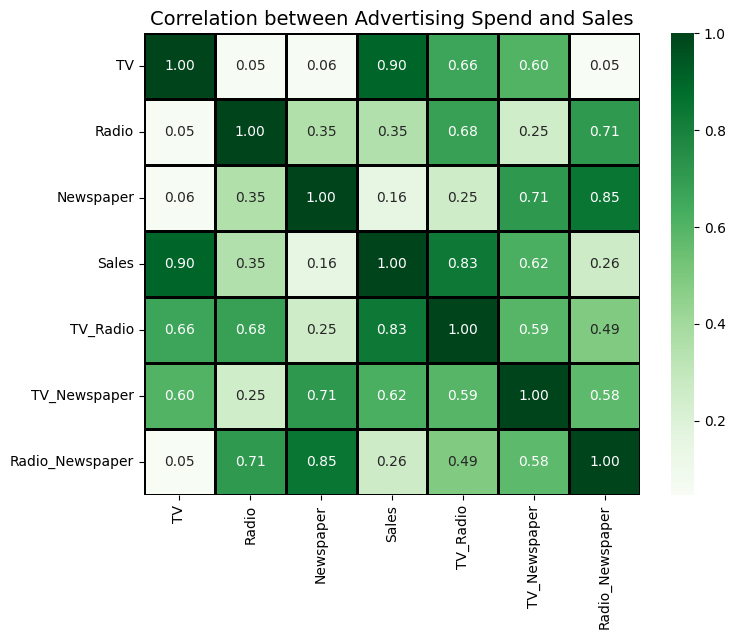

In [14]:
# Compute correlation matrix
corr_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt=".2f", linewidths=1, linecolor='black')
plt.title('Correlation between Advertising Spend and Sales', fontsize=14)
plt.show()

## Prediction

In [15]:

# target variable
y = data['Sales']

# features (all columns except Rating)
X = data.drop('Sales', axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
X_train.shape,y_train.shape 


((160, 6), (160,))

The accuracy of the Linear Regression Model Train is 91.03
The accuracy of the  Linear Regression Model Test is 92.44


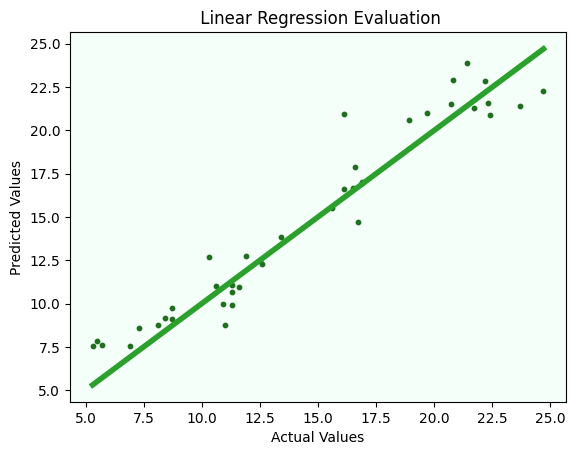


The accuracy of the Random Forest Model Train is 99.40
The accuracy of the  Random Forest Model Test is 96.01


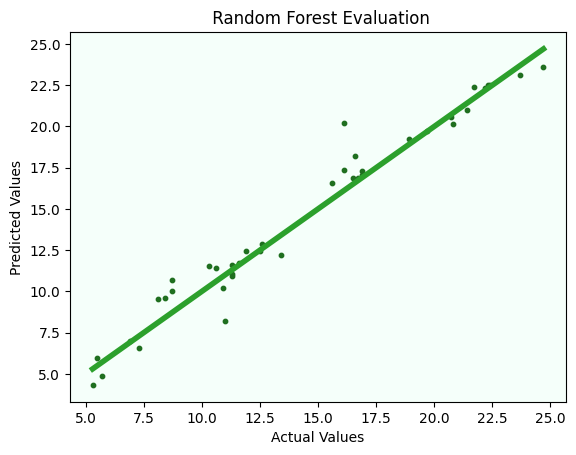


The accuracy of the Gradient Boost Model Train is 99.72
The accuracy of the  Gradient Boost Model Test is 96.26


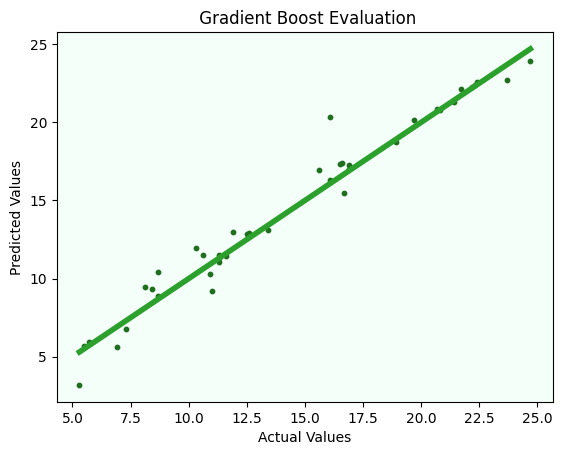


The accuracy of the XGBoost Model Train is 100.00
The accuracy of the  XGBoost Model Test is 96.37


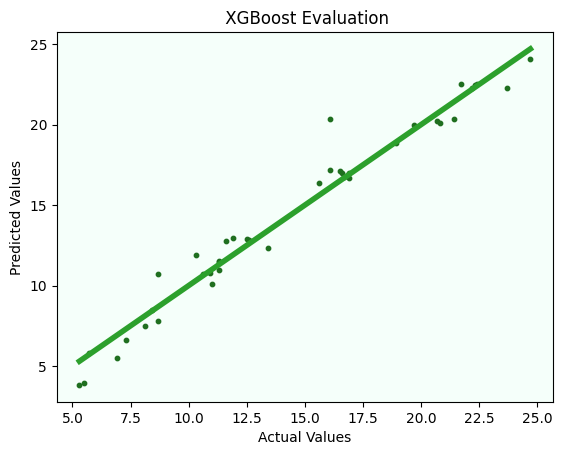


The accuracy of the KNN Model Train is 88.93
The accuracy of the  KNN Model Test is 86.11


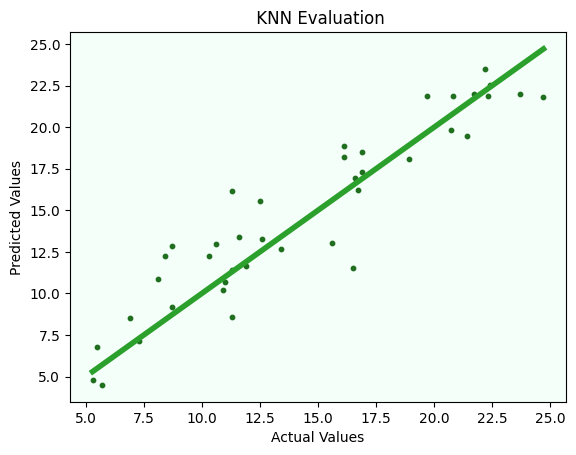


The accuracy of the Decision Tree Model Train is 100.00
The accuracy of the  Decision Tree Model Test is 92.09


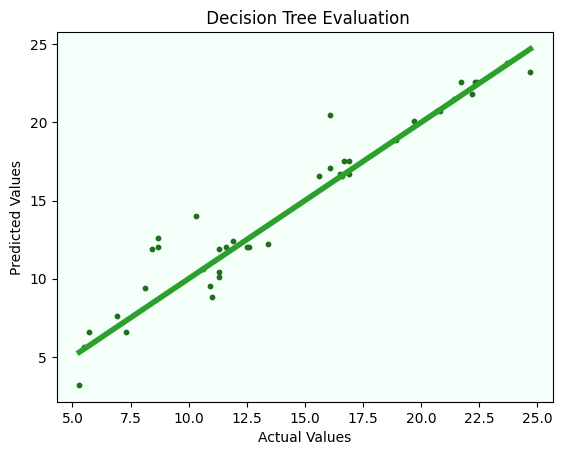


The accuracy of the Bagging Regressor Model Train is 99.39
The accuracy of the  Bagging Regressor Model Test is 96.10


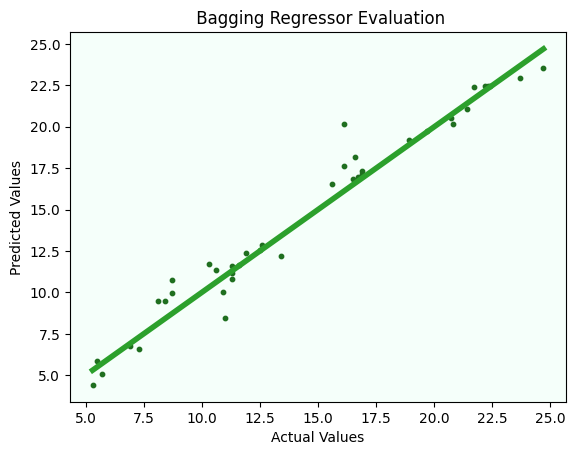

,Model,Accuracy,MSE,R2_score
0,Linear Regression,0.924352,2.337596,0.924352
1,Random Forest,0.960108,1.232703,0.960108
2,Gradient Boost,0.962578,1.156374,0.962578
3,XGBoost,0.963684,1.122195,0.963684
4,KNN,0.861067,4.293170,0.861067
5,Decision Tree,0.920885,2.444750,0.920885
6,Bagging Regressor,0.961008,1.204907,0.961008


In [17]:
results = []

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boost', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('KNN',KNeighborsRegressor(n_neighbors=5)),
    ('Decision Tree',DecisionTreeRegressor(random_state=42)),
    ('Bagging Regressor',BaggingRegressor(n_estimators=150, random_state=42))
          ]


for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    results.append((name, accuracy, MSE, R2_score))
    acc = (model.score(X_train , y_train)*100)
    print(f'The accuracy of the {name} Model Train is {acc:.2f}')
    acc =(model.score(X_test , y_test)*100)
    print(f'The accuracy of the  {name} Model Test is {acc:.2f}')
    plt.scatter(y_test, y_pred,s=10,color='#1f6f1f')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f' {name} Evaluation')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='#2ca02c', linewidth = 4)
    # set chart background color
    plt.gca().set_facecolor('mintcream')
    plt.show()
    print()

dff = pd.DataFrame(results, columns=['Model', 'Accuracy', 'MSE', 'R2_score'])
df_styled_best = dff.style.highlight_max(subset=['Accuracy','R2_score'], color='green').highlight_min(subset=['MSE'], color='green').highlight_max(subset=['MSE'], color='red').highlight_min(subset=['Accuracy','R2_score'], color='red')

display(df_styled_best)
